<a href="https://colab.research.google.com/github/FabioRochaPoeta/wine-case/blob/main/An%C3%A1lise_supervisionada_Modelos_al%C3%A9m_da_Regress%C3%A3o_Log%C3%ADstica_Dados_Vinho_Tinto_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Novos Modelos

![](https://media.giphy.com/media/E3L5goMMSoAAo/giphy.gif)



## Lembrando as variáveis do nosso problema

Usaremos um dataset composto por propriedades físico-químicas de vinhos tintos. Temos 1599 amostras e um total de 11 variáveis independentes, descritas abaixo:

 - `fixed acidity`: a maioria dos ácidos envolvidos com vinho (não evaporam prontamente)
 - `volatile acidity`: a quantidade de ácido acético no vinho, que em níveis muito altos pode levar a um gosto desagradável de vinagre
 - `citric acid`: encontrado em pequenas quantidades, o ácido cítrico pode adicionar "leveza" e sabor aos vinhos
 - `residual sugar`: a quantidade de açúcar restante após a fermentação é interrompida, é raro encontrar vinhos com menos de 1 grama / litro e vinhos com mais de 45 gramas / litro são considerados doces
 - `chlorides`: a quantidade de sal no vinho
free sulfur dioxide: a forma livre de SO2 existe em equilíbrio entre o SO2 molecular (como gás dissolvido) e o íon bissulfito; impede o crescimento microbiano e a oxidação do vinho
 - `total sulfur dioxide`: Quantidade de formas livres e encadernadas de S02; em baixas concentrações, o SO2 é quase indetectável no vinho, mas nas concentrações de SO2 acima de 50 ppm, o SO2 se torna evidente no nariz e no sabor do vinho.
 - `density`: a densidade do vinho é próxima a da água, dependendo do percentual de álcool e teor de açúcar
 - `pH`: descreve se o vinho é ácido ou básico numa escala de 0 (muito ácido) a 14 (muito básico); a maioria dos vinhos está entre 3-4 na escala de pH
 - `sulphates`: um aditivo de vinho que pode contribuir para os níveis de gás de dióxido de enxofre (S02), que age como um antimicrobiano e antioxidante
 - `alcohol`: o percentual de álcool no vinho


Existe ainda uma variável chamada `quality`. Essa variável é uma nota de qualidade do vinho que varia de 0 a 10.

Criamos uma variável que determina se um vinho é considerado bom ou ruim, baseado na quality. Se quality > 5, o vinho é bom. 

In [ ]:
# Import necessary packages
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from copy import deepcopy as cp
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.tree import (
    DecisionTreeClassifier, 
    plot_tree
)

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold)
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    RocCurveDisplay
)

sns.set_style("ticks")
sns.set_context("paper")

random_state = 42

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
wine = pd.read_csv(url, sep=";")
wine["category"] = (wine.quality > 5).astype(float)

vars = [
   'fixed acidity',
   'volatile acidity',
   'citric acid',
   'residual sugar',
   'chlorides',
   'free sulfur dioxide',
   'total sulfur dioxide',
   'density',
   'pH',
   'sulphates',
   'alcohol'
]

X = wine[vars]
y = wine['category']

# Treinamento com validação cruzada

![](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

In [ ]:
X_train_cv, X_test, y_train_cv, y_test = train_test_split(X.values,
                                                          y.values,
                                                          test_size=0.2, # 20 % da base
                                                          random_state=42,
                                                          stratify=y)

def train(X, y, model_klass, model_kwargs = {}):
    cv = StratifiedKFold(n_splits=5)
    f1_score_val_list = []
    f1_score_train_list = []
    model_list =[]
    scaler_list = []
    # Validação cruzada só em Training Data
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_train = X[train_idx, :]
        y_train = y[train_idx]
        X_val = X[val_idx, :]
        y_val = y[val_idx]

        # Escala
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        scaler_list.append(scaler)

        # Treino
        model = model_klass(**model_kwargs)
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_train_scaled)

        y_pred_val = model.predict(X_val_scaled)
        print(f"========================= FOLD {fold} ==========================")
        print(f"Meu resultado para treino de F1-Score é {f1_score(y_train, y_pred):.2}")
        print(f"Meu resultado para validação de F1-Score é {f1_score(y_val, y_pred_val):.2}") 
        f1_score_val_list.append(f1_score(y_val, y_pred_val))
        f1_score_train_list.append(f1_score(y_train, y_pred))
        model_list.append(model)
    print()
    print()
    print(f"Meu resultado de F1-Score Médio de treino é {np.mean(f1_score_train_list): .2} +- {np.std(f1_score_train_list): .2} ")
    print(f"Meu resultado de F1-Score Médio de validação é {np.mean(f1_score_val_list): .2} +- {np.std(f1_score_val_list): .2} ")
    print()

    best_model_idx = np.argmax(f1_score_val_list)
    print(f"Meu melhor fold é: {best_model_idx} ")
    best_model = model_list[best_model_idx]

    # Fazer a inferência em Test Data
    best_scaler = scaler_list[best_model_idx]
    X_test_scaled = best_scaler.transform(X_test)
    y_pred_test = model.predict(X_test_scaled)

    print()
    print()
    print(f"Meu resultado de F1-Score para o conjunto de teste é: {f1_score(y_test, y_pred_test):.2} ")
    return best_model

In [ ]:
train(X_train_cv, y_train_cv, LogisticRegression)

========================= FOLD 0 ==========================
Meu resultado para treino de F1-Score é 0.76
Meu resultado para validação de F1-Score é 0.75
========================= FOLD 1 ==========================
Meu resultado para treino de F1-Score é 0.77
Meu resultado para validação de F1-Score é 0.72
========================= FOLD 2 ==========================
Meu resultado para treino de F1-Score é 0.76
Meu resultado para validação de F1-Score é 0.76
========================= FOLD 3 ==========================
Meu resultado para treino de F1-Score é 0.76
Meu resultado para validação de F1-Score é 0.76
========================= FOLD 4 ==========================
Meu resultado para treino de F1-Score é 0.75
Meu resultado para validação de F1-Score é 0.79


Meu resultado de F1-Score Médio de treino é  0.76 +-  0.007 
Meu resultado de F1-Score Médio de validação é  0.76 +-  0.024 

Meu melhor fold é: 4 


Meu resultado de F1-Score para o conjunto de teste é: 0.75 


LogisticRegression()

In [ ]:
tree_model = train(X_train_cv, y_train_cv, DecisionTreeClassifier)

========================= FOLD 0 ==========================
Meu resultado para treino de F1-Score é 1.0
Meu resultado para validação de F1-Score é 0.73
========================= FOLD 1 ==========================
Meu resultado para treino de F1-Score é 1.0
Meu resultado para validação de F1-Score é 0.77
========================= FOLD 2 ==========================
Meu resultado para treino de F1-Score é 1.0
Meu resultado para validação de F1-Score é 0.75
========================= FOLD 3 ==========================
Meu resultado para treino de F1-Score é 1.0
Meu resultado para validação de F1-Score é 0.74
========================= FOLD 4 ==========================
Meu resultado para treino de F1-Score é 1.0
Meu resultado para validação de F1-Score é 0.79


Meu resultado de F1-Score Médio de treino é  1.0 +-  0.0 
Meu resultado de F1-Score Médio de validação é  0.76 +-  0.02 

Meu melhor fold é: 4 


Meu resultado de F1-Score para o conjunto de teste é: 0.76 


In [ ]:
tree_model = train(X_train_cv, y_train_cv, DecisionTreeClassifier, model_kwargs={'min_samples_leaf': 10})

========================= FOLD 0 ==========================
Meu resultado para treino de F1-Score é 0.85
Meu resultado para validação de F1-Score é 0.73
========================= FOLD 1 ==========================
Meu resultado para treino de F1-Score é 0.85
Meu resultado para validação de F1-Score é 0.73
========================= FOLD 2 ==========================
Meu resultado para treino de F1-Score é 0.85
Meu resultado para validação de F1-Score é 0.74
========================= FOLD 3 ==========================
Meu resultado para treino de F1-Score é 0.85
Meu resultado para validação de F1-Score é 0.72
========================= FOLD 4 ==========================
Meu resultado para treino de F1-Score é 0.85
Meu resultado para validação de F1-Score é 0.75


Meu resultado de F1-Score Médio de treino é  0.85 +-  0.0025 
Meu resultado de F1-Score Médio de validação é  0.73 +-  0.0089 

Meu melhor fold é: 4 


Meu resultado de F1-Score para o conjunto de teste é: 0.71 


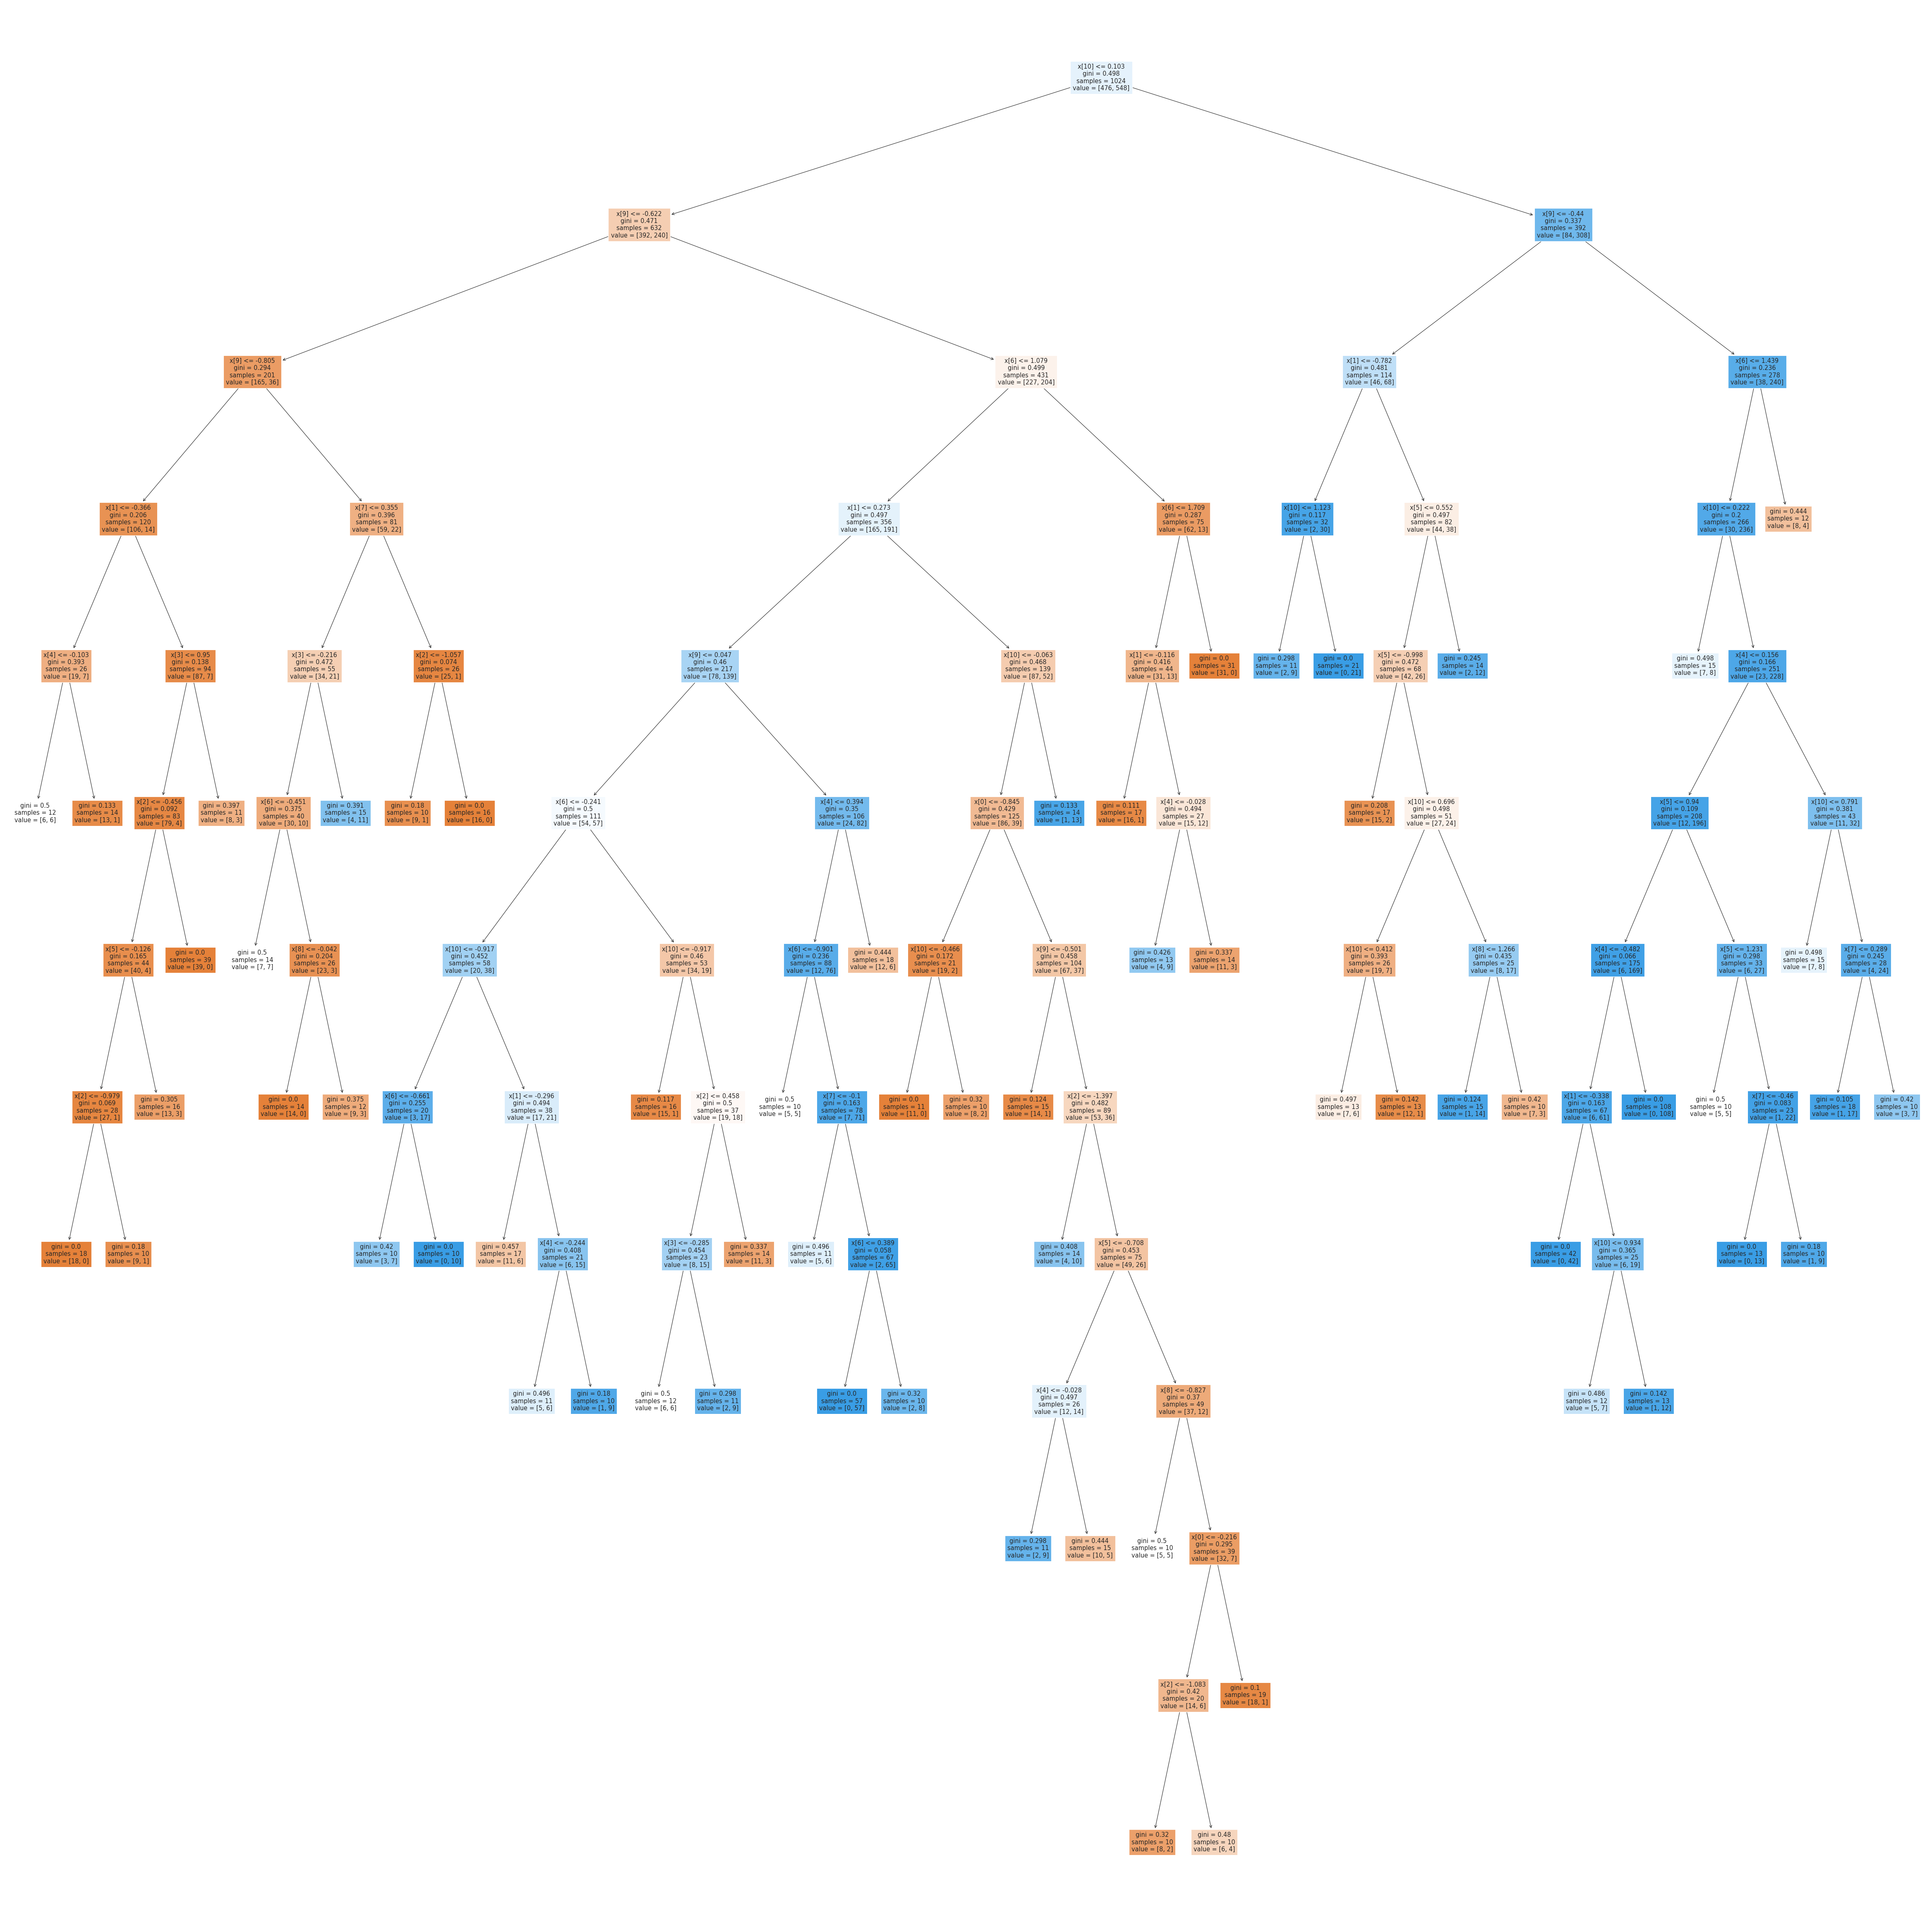

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(60, 60))
plot_tree(tree_model, filled=True);

In [ ]:
DecisionTreeClassifier?